## Setup

In [1]:
import os
os.chdir(os.path.expanduser('~/seabass/src/'))
print("Current working directory: {0}".format(os.getcwd()))

#import libraries and models 
import seabass
import lmm_hier
import torch
import scipy.special
import scipy.stats
import plotnine as p9
import pickle

import matplotlib.pyplot as plt
import sys
import pyro
import pandas as pd
from pathlib import Path
import numpy as np
import datetime 

import statsmodels.stats.multitest # .fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False)[source]

from importlib import reload  # Python 3.4+

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == "cpu": torch.set_num_threads(20)

p9.themes.theme_set(p9.themes.theme_bw(base_size = 14))

class StopExecution(Exception):
    def _render_traceback_(self):
        return []


Current working directory: /gpfs/commons/home/daknowles/seabass/src


/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
input_file = "/gpfs/commons/groups/knowles_lab/cas13_share/data/2022-02-23_all_reps/2022-02-23_R1_remove_TechPool-normalized_wnobatch_corMS_LFC_all_guides_Harm_Code.txt.gz"

dat = pd.read_csv(input_file, sep = "\t")

nt_data = seabass.ScreenData.from_pandas(dat[dat["type"]=="NT"] , device = device) 

essential_data = seabass.ScreenData.from_pandas(dat[dat["type"]=="essential"] , device = device) 


## Do random slopes improve model fit?

Optimizing: sigma_noise noise_t_df
Stalled after 20 iterations. Increasing num_particles to 2.


/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'slope_t_df'}


Stalled after 24 iterations. Increasing num_particles to 4.
Stalled after 17 iterations. Increasing num_particles to 8.
Stalled after 12 iterations. Increasing num_particles to 16.
Stalled after 12 iterations. Increasing num_particles to 32.
Stalled after 12 iterations. Increasing num_particles to 64.
Optimizing: sigma_noise slope_noise noise_t_df slope_t_df
Stalled after 36 iterations. Increasing num_particles to 2.
Stalled after 53 iterations. Increasing num_particles to 4.
Stalled after 22 iterations. Increasing num_particles to 8.
Stalled after 19 iterations. Increasing num_particles to 16.
Stalled after 24 iterations. Increasing num_particles to 32.
Stalled after 16 iterations. Increasing num_particles to 64.


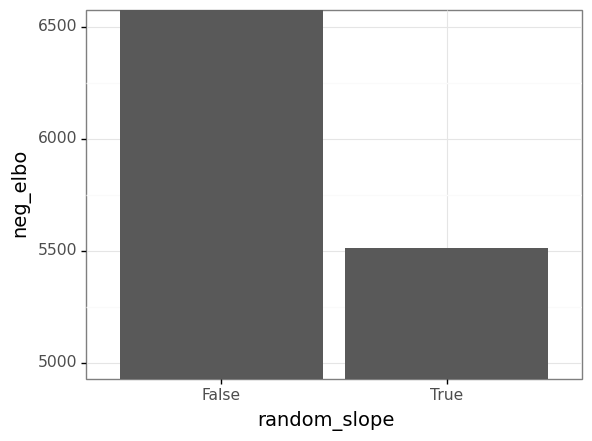

<ggplot: (8794551771895)>

In [3]:
hierarchical_noise = False
hierarchical_slope = False

elbos = {}

for slope_noise in [0.,None]:

    model, guide, losses, nt_posterior, optim_record = lmm_hier.fit(
        nt_data, 
        hierarchical_noise=hierarchical_noise, 
        hierarchical_slope=hierarchical_slope,
        NT_model=True, 
        slope_noise = slope_noise
    )

    elbos[slope_noise] = losses[-1]

elbos_df = pd.DataFrame(
    [ [k,v] for k,v in elbos.items()], 
    columns = ["slope_noise","neg_elbo"])

elbos_df["random_slope"] = np.isnan(elbos_df.slope_noise)

# fit is much better with random slopes included (although could be overfitting)
p9.ggplot(elbos_df, p9.aes("random_slope", "neg_elbo")) + p9.geom_col(position = "dodge") + p9.coord_cartesian(ylim=[5000,6500])

## What noise distribution should we use?

In [41]:
my_file = Path("compare_noise_dist.pkl")
if my_file.is_file():
    elbos_df = pickle.load(open(my_file,"rb"))
    raise StopExecution()
    
neg_elbos = {}

for noise_t_df in [0.,1.,np.inf,None]:
    
    for slope_t_df in [0.,1.,np.inf,None]:

        model, guide, losses, nt_posterior, optim_record = lmm_hier.fit(
            nt_data, 
            hierarchical_noise=hierarchical_noise, 
            hierarchical_slope=hierarchical_slope,
            per_gene_variance = False,
            NT_model=True, 
            noise_t_df = noise_t_df, 
            slope_t_df = slope_t_df
        )
        
        neg_elbos[(noise_t_df,slope_t_df)] = losses[-1]

elbos_df = pd.DataFrame(
    [ list(k)+[v] for k,v in neg_elbos.items() ],
    columns = ["noise_t_df","slope_t_df","neg_elbo"])

relabel = lambda df: df.map(
    '{:.0f}'.format).replace(
    "nan", "Student-t").replace(
    "0", "Laplace").replace(
    "1", "Cauchy").replace(
    "inf", "Gaussian")

elbos_df.noise_t_df = relabel(elbos_df.noise_t_df)
elbos_df.slope_t_df = relabel(elbos_df.slope_t_df)

with open(my_file, "wb") as f:
    pickle.dump(elbos_df, f)

StopExecution: 

In [43]:
elbos_df = pd.DataFrame(
    [ list(k)+[v] for k,v in neg_elbos.items() ],
    columns = ["noise_t_df","slope_t_df","neg_elbo"])

relabel = lambda df: df.map(
    '{:.0f}'.format).replace(
    "nan", "Student-t").replace(
    "0", "Laplace").replace(
    "1", "Cauchy").replace(
    "inf", "Gaussian")

elbos_df.noise_t_df = relabel(elbos_df.noise_t_df)
elbos_df.slope_t_df = relabel(elbos_df.slope_t_df)

with open(my_file, "wb") as f:
    pickle.dump(elbos_df, f)

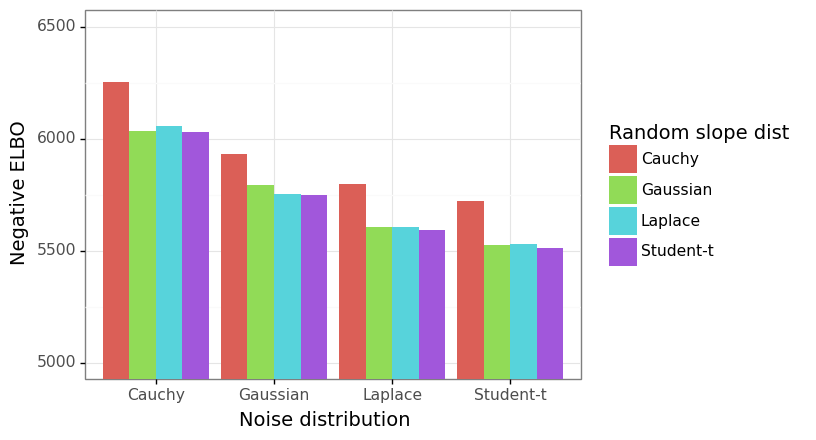

<ggplot: (8794495400623)>

In [50]:
# Student-t with learnt dof looks best
p9.ggplot(elbos_df, p9.aes("noise_t_df",  "neg_elbo", fill = "slope_t_df")) + p9.geom_col(position = "dodge") + p9.coord_cartesian(ylim=[5000,6500]) + p9.xlab("Noise distribution") + p9.guides(fill=p9.guide_legend(title="Random slope dist")) + p9.ylab("Negative ELBO")

In [51]:
model, guide, losses, nt_posterior, optim_record = lmm_hier.fit(
    nt_data, 
    hierarchical_noise=hierarchical_noise, 
    hierarchical_slope=hierarchical_slope,
    NT_model=True, 
    noise_t_df = None, 
    slope_t_df = None
)

{ k : nt_posterior[k].item() for k,v in nt_posterior.items() if np.size(v)==1}

Optimizing: sigma_noise slope_noise noise_t_df slope_t_df
Stalled after 67 iterations. Increasing num_particles to 2.
Stalled after 22 iterations. Increasing num_particles to 4.
Stalled after 26 iterations. Increasing num_particles to 8.
Stalled after 17 iterations. Increasing num_particles to 16.
Stalled after 21 iterations. Increasing num_particles to 32.
Stalled after 19 iterations. Increasing num_particles to 64.


{'sigma_noise': 0.3449386656284332,
 'slope_noise': 0.28868424892425537,
 'noise_t_df': 4.614202499389648,
 'slope_t_df': 9.198185920715332}

In [69]:
    
all_hypers = ["sigma_noise", "log_slope_noise_mean", "log_slope_noise_std", 'slope_noise', "log_sigma_noise_mean", "log_sigma_noise_std", "noise_t_df", "slope_t_df"]

# assessment: positive slopes are false positives, negative slopes are good.
def get_perf(post, alpha = 0.05):
    sig,q = statsmodels.stats.multitest.fdrcorrection(post["p"], alpha=alpha)
    fp = np.logical_and(post["z"]>0, sig)
    tp = np.logical_and(post["z"]<0, sig)
    return(np.mean(sig), np.mean(fp), np.mean(tp))

my_file = Path("lmm_fixed_init.pkl")
if my_file.is_file():
    res = pickle.load(open(my_file,"rb"))
    raise StopExecution()

res = {}

for hierarchical_noise in (False, True):
    for hierarchical_slope in (False, True):
        
        model, guide, losses, nt_posterior, optim_record = lmm_hier.robustifier(
            lmm_hier.fit,
            10, # max attempts
            nt_data, 
            hierarchical_noise=hierarchical_noise, 
            hierarchical_slope=hierarchical_slope,
            NT_model=True
        )
            
        for t_df in [0.,1.,np.inf,None]:

            model, guide, losses, essential_posterior, optim_record = lmm_hier.robustifier(
                lmm_hier.fit,
                10, 
                essential_data, 
                hierarchical_noise=hierarchical_noise, 
                hierarchical_slope=hierarchical_slope,
                NT_model = False,
                t_df = t_df
            )

            res[(hierarchical_noise,hierarchical_slope,False,t_df)] = get_perf(essential_posterior)

            kwargs = { k : nt_posterior[k].item() for k in nt_posterior if k in all_hypers}
            
            model, guide, losses, essential_posterior, optim_record = lmm_hier.robustifier(
                lmm_hier.fit, 
                10,
                essential_data, 
                hierarchical_noise=hierarchical_noise, 
                hierarchical_slope=hierarchical_slope,
                NT_model = False, 
                t_df = t_df,
                **kwargs
            )
            
            res[(hierarchical_noise,hierarchical_slope,True,t_df)] = get_perf(essential_posterior)            

with open(my_file, "wb") as f:
    pickle.dump(res, f)

StopExecution: 

In [70]:
res_df = pd.DataFrame([ list(k)+list(v) for k,v in res.items() ], columns = ["hier_noise","hier_slope","NT_fit","t","prop_sig","fpr","tpr"])
res_df["ttpr"] = res_df.tpr - res_df.fpr
res_df["fdr"] = 2 * res_df.fpr / res_df.tpr
res_df.sort_values("ttpr")

,hier_noise,hier_slope,NT_fit,t,prop_sig,fpr,tpr,ttpr,fdr
12,False,True,False,inf,0.090946,0.001724,0.089222,0.087499,0.038637
28,True,True,False,inf,0.093348,0.002150,0.091198,0.089048,0.047144
14,False,True,False,NaN,0.093716,0.001433,0.092282,0.090849,0.031060
30,True,True,False,NaN,0.099526,0.001762,0.097763,0.096001,0.036054
10,False,True,False,1.0,0.103263,0.001588,0.101675,0.100087,0.031238
26,True,True,False,1.0,0.104658,0.001879,0.102779,0.100901,0.036555
8,False,True,False,0.0,0.106071,0.001975,0.104096,0.102121,0.037953
24,True,True,False,0.0,0.107950,0.002440,0.105510,0.103070,0.046256
18,True,False,False,1.0,0.108047,0.002014,0.106033,0.104019,0.037991
2,False,False,False,1.0,0.108008,0.001704,0.106304,0.104600,0.032064


In [71]:
res_df[res_df.NT_fit].sort_values("ttpr")

,hier_noise,hier_slope,NT_fit,t,prop_sig,fpr,tpr,ttpr,fdr
19,True,False,True,1.0,0.112617,0.002498,0.110119,0.107621,0.045375
23,True,False,True,NaN,0.113489,0.002479,0.111010,0.108531,0.044662
3,False,False,True,1.0,0.113334,0.002130,0.111204,0.109073,0.038314
7,False,False,True,NaN,0.114961,0.002305,0.112656,0.110352,0.040915
27,True,True,True,1.0,0.116607,0.002886,0.113721,0.110836,0.050749
11,False,True,True,1.0,0.117808,0.002808,0.115000,0.112191,0.048838
31,True,True,True,NaN,0.120112,0.003699,0.116413,0.112714,0.063550
15,False,True,True,NaN,0.119551,0.003273,0.116278,0.113005,0.056296
17,True,False,True,0.0,0.119318,0.003079,0.116239,0.113160,0.052982
1,False,False,True,0.0,0.119706,0.002847,0.116859,0.114012,0.048724


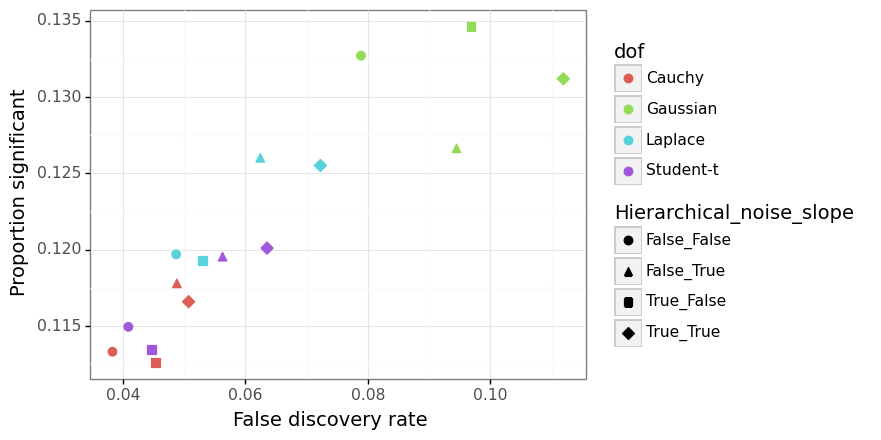

<ggplot: (8794538628461)>

In [72]:
res_df["dof"] = relabel(res_df.t)

res_df["Hierarchical_noise_slope"] = res_df.hier_noise.astype(str) + "_" + res_df.hier_slope.astype(str)

p9.ggplot(res_df[res_df.NT_fit], p9.aes("fdr", "prop_sig", color = "dof", shape = "Hierarchical_noise_slope")) + p9.geom_point(size=3) + p9.xlab("False discovery rate") + p9.ylab("Proportion significant") #  + p9.expand_limits(x=0,y=0)

In [81]:
hierarchical_noise = False
hierarchical_slope=False

my_file = Path("lmm_multiple_init.pkl")
if my_file.is_file():
    print("Found",my_file)
    neg_elbos,res,posts,kwargs = pickle.load(open(my_file,"rb"))
    raise StopExecution()

model, guide, losses, nt_posterior, optim_record = lmm_hier.fit(
    nt_data, 
    hierarchical_noise = hierarchical_noise, 
    hierarchical_slope = hierarchical_slope,
    NT_model=True, 
    noise_t_df = None, 
    slope_t_df = None, 
    slope_noise = None
)

kwargs = { k : nt_posterior[k].item() for k in nt_posterior if k in all_hypers}

res = {}
posts = {}
neg_elbos = {}

for rep in [0,1]: 

    res[rep] = {}
    posts[rep] = {}
    neg_elbos[rep] = {}

    for t_df in [0.,np.inf,None]:

        model, guide, losses, posts[rep][t_df], optim_record = lmm_hier.robustifier(
            lmm_hier.fit, 
            10,
            essential_data, 
            hierarchical_noise = hierarchical_noise, 
            hierarchical_slope = hierarchical_slope,
            NT_model = False, 
            t_df = t_df,
            **kwargs
        )

        neg_elbos[rep][t_df] = losses[-1]
        res[rep][t_df] = get_perf(posts[rep][t_df])

with open(my_file, "wb") as f:
    pickle.dump([neg_elbos,res,posts,kwargs], f)

Found lmm_multiple_init.pkl


StopExecution: 

In [82]:
post_df = {}
for rep in posts: 
    post_df[rep] = {}
    for t_df in posts[rep]:
        post_df[rep][t_df] = pd.DataFrame( {k:posts[rep][t_df][k] for k in ['guide_score', 'guide_score_se', 'z', 'p', 'sig', 'q']})

In [83]:
res_df = pd.DataFrame([ [k] + [kk] + list(vv) + [neg_elbos[k][kk] ] for k,v in res.items() for kk,vv in v.items()  ], columns = ["rep","t_df","prop_sig","fpr","tpr","neg_elbo"])
res_df["ttpr"] = res_df.tpr - res_df.fpr
res_df["fdr"] = 2 * res_df.fpr / res_df.tpr
res_df.sort_values("ttpr") # 

,rep,t_df,prop_sig,fpr,tpr,neg_elbo,ttpr,fdr
5,1,NaN,0.105122,0.001569,0.103554,407229.084061,0.101985,0.030297
2,0,NaN,0.105955,0.001511,0.104445,407250.118281,0.102934,0.028926
3,1,0.0,0.109848,0.002072,0.107776,407635.301363,0.105703,0.038455
0,0,0.0,0.110177,0.002053,0.108124,407695.882354,0.106071,0.037972
1,0,inf,0.116007,0.002963,0.113043,409480.850102,0.110080,0.052424
4,1,inf,0.117362,0.003079,0.114283,409581.530656,0.111204,0.053889


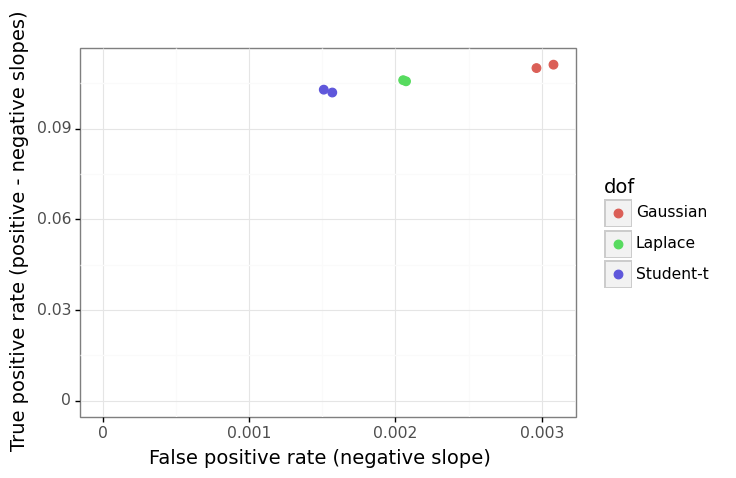

<ggplot: (8794486938224)>

In [84]:
res_df["dof"] = relabel(res_df.t_df)

p9.ggplot(res_df, p9.aes("fpr", "ttpr", color = "dof")) + p9.geom_point(size=3) + p9.xlab("False positive rate (negative slope)") + p9.ylab("True positive rate (positive - negative slopes)") + p9.expand_limits(x=0,y=0)

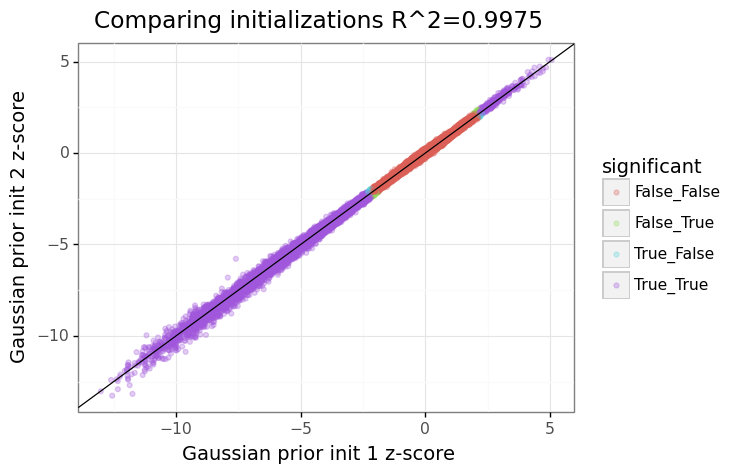

<ggplot: (8794525099530)>

In [85]:
df = pd.concat([post_df[0][np.inf].add_suffix('_1'), post_df[1][np.inf].add_suffix('_2')], axis=1)
df["significant"] = df.sig_1.astype(str) + "_" + df.sig_2.astype(str)
R,_ = scipy.stats.pearsonr(df["z_1"],df["z_2"])

p9.ggplot( 
    df, 
    p9.aes("z_1","z_2", color = "significant")) + p9.geom_point(alpha = 0.3) + p9.xlab("Gaussian prior init 1 z-score") + p9.ylab("Gaussian prior init 2 z-score") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing initializations R^2=%.4f" % R**2)

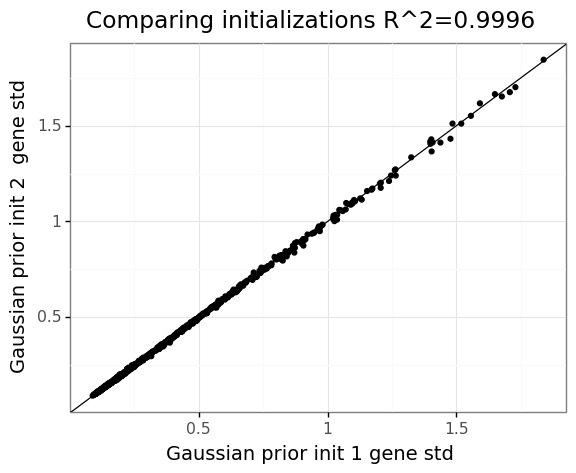

<ggplot: (8794537087467)>

In [86]:
x = posts[0][np.inf]["guide_std"]
y = posts[1][np.inf]["guide_std"]
R,_ = scipy.stats.pearsonr(x,y)

p9.qplot(x, y) + p9.xlab("Gaussian prior init 1 gene std") + p9.ylab("Gaussian prior init 2  gene std") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing initializations R^2=%.4f" % R**2)

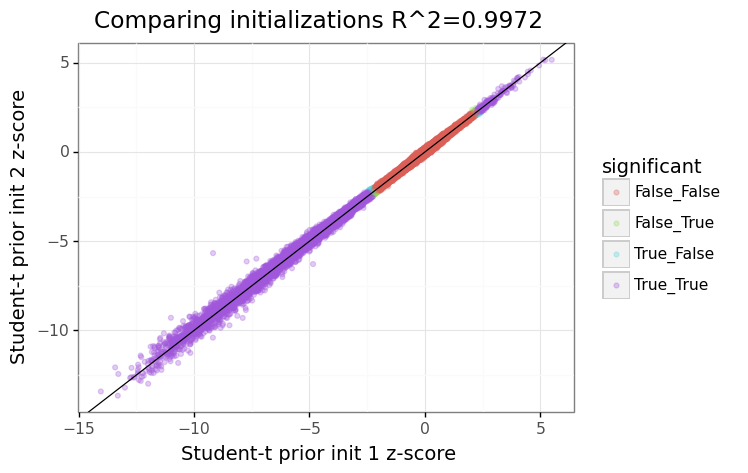

<ggplot: (8794486935601)>

In [87]:
df = pd.concat([post_df[0][None].add_suffix('_1'), post_df[1][None].add_suffix('_2')], axis=1)
df["significant"] = df.sig_1.astype(str) + "_" + df.sig_2.astype(str)
R,_ = scipy.stats.pearsonr(df["z_1"],df["z_2"])

p9.ggplot( 
    df, 
    p9.aes("z_1","z_2", color = "significant")) + p9.geom_point(alpha = 0.3) + p9.xlab("Student-t prior init 1 z-score") + p9.ylab("Student-t prior init 2 z-score") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing initializations R^2=%.4f" % R**2)

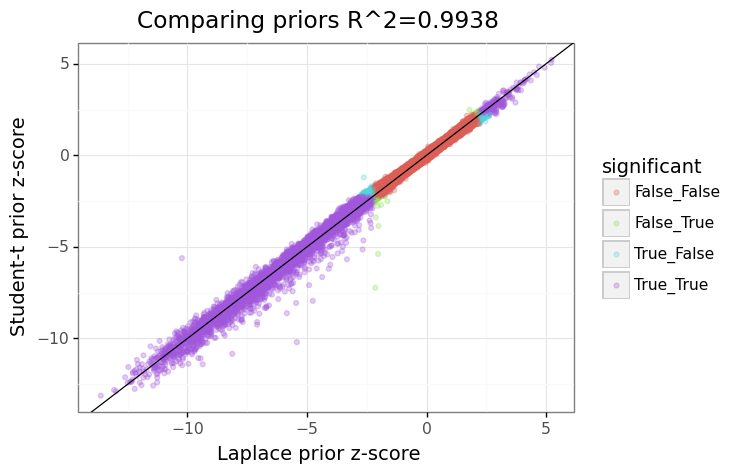

<ggplot: (8794537181311)>

In [19]:
df = pd.concat([post_df[0][0.].add_suffix('_1'), post_df[0][None].add_suffix('_2')], axis=1)
df["significant"] = df.sig_1.astype(str) + "_" + df.sig_2.astype(str)
R,_ = scipy.stats.pearsonr(df["z_1"],df["z_2"])

p9.ggplot( 
    df, 
    p9.aes("z_1","z_2", color = "significant")) + p9.geom_point(alpha = 0.3) + p9.xlab("Laplace prior z-score") + p9.ylab("Student-t prior z-score") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing priors R^2=%.4f" % R**2)

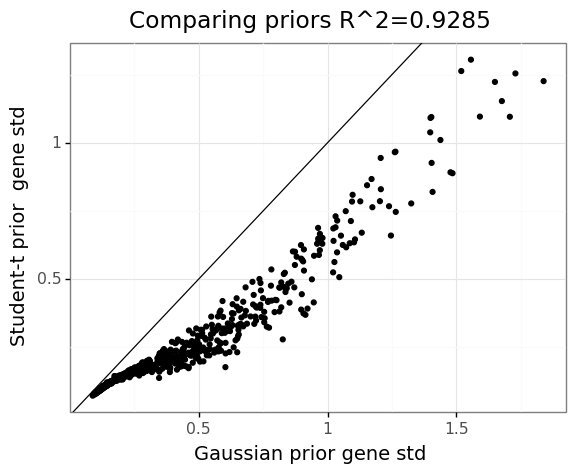

<ggplot: (8794480734657)>

In [88]:
x = posts[0][np.inf]["guide_std"]
y = posts[0][None]["guide_std"]
R,_ = scipy.stats.pearsonr(x,y)

p9.qplot(x, y) + p9.xlab("Gaussian prior gene std") + p9.ylab("Student-t prior  gene std") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing priors R^2=%.4f" % R**2)

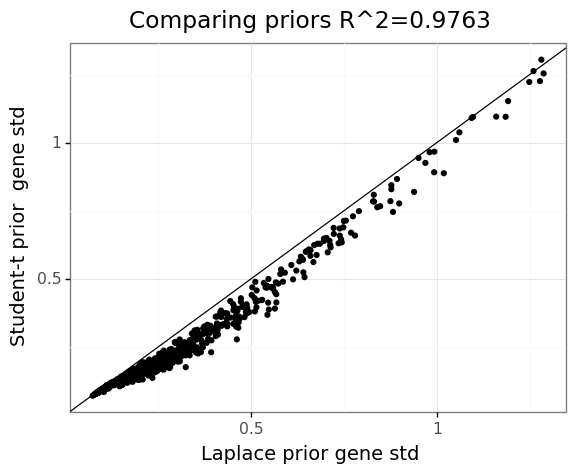

<ggplot: (8794537132008)>

In [89]:
x = posts[0][0.]["guide_std"]
y = posts[0][None]["guide_std"]
R,_ = scipy.stats.pearsonr(x,y)

p9.qplot(x, y) + p9.xlab("Laplace prior gene std") + p9.ylab("Student-t prior  gene std") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing priors R^2=%.4f" % R**2)

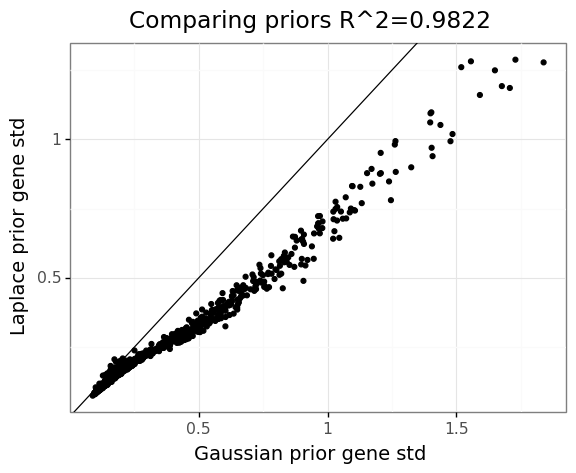

<ggplot: (8794538639424)>

In [90]:
x = posts[0][np.inf]["guide_std"]
y = posts[0][0.]["guide_std"]
R,_ = scipy.stats.pearsonr(x,y)

p9.qplot(x, y) + p9.xlab("Gaussian prior gene std") + p9.ylab("Laplace prior gene std") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing priors R^2=%.4f" % R**2)

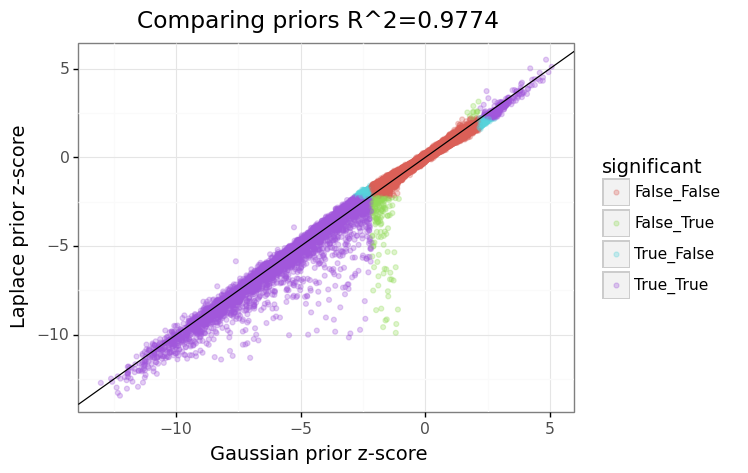

<ggplot: (8794538626344)>

In [94]:
df = pd.concat([post_df[0][np.inf].add_suffix('_1'), post_df[0][0.].add_suffix('_2')], axis=1)
df["significant"] = df.sig_1.astype(str) + "_" + df.sig_2.astype(str)
R,_ = scipy.stats.pearsonr(df["z_1"],df["z_2"])

p9.ggplot( 
    df, 
    p9.aes("z_1","z_2", color = "significant")) + p9.geom_point(alpha = 0.3) + p9.xlab("Gaussian prior z-score") + p9.ylab("Laplace prior z-score") + p9.geom_abline(intercept=0, slope=1) + p9.ggtitle("Comparing priors R^2=%.4f" % R**2)

## Significant under Laplace/Student-t but not Gaussian

Gaussian z-score  -1.165298
Laplace z-score  -9.389838
Student-t z-score  -12.287978


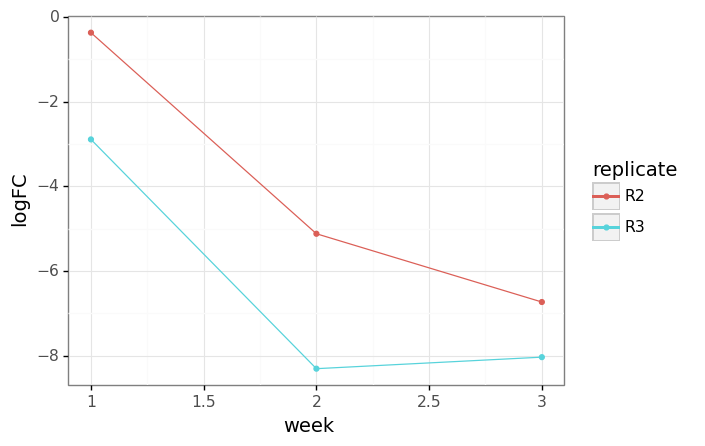

<ggplot: (8794557462763)>

In [92]:
weird_junc = (posts[0][np.inf]["z"] - posts[0][None]["z"]).argmax() # get same one for Laplace
print("Gaussian z-score ", posts[0][np.inf]["z"][weird_junc]) 
print("Laplace z-score ", posts[0][0.]["z"][weird_junc])
print("Student-t z-score ", posts[0][None]["z"][weird_junc]) 
weird_junc_name = essential_data.sgrnas[weird_junc]
p9.ggplot(dat[dat.sgrna == weird_junc_name], p9.aes("week","logFC",color="replicate")) + p9.geom_point() + p9.geom_line()

## Significant under Gaussian but not Student-t/Laplace

Gaussian z-score  -2.811089
Student-t z-score  -2.0406444
Laplace z-score  -2.171903


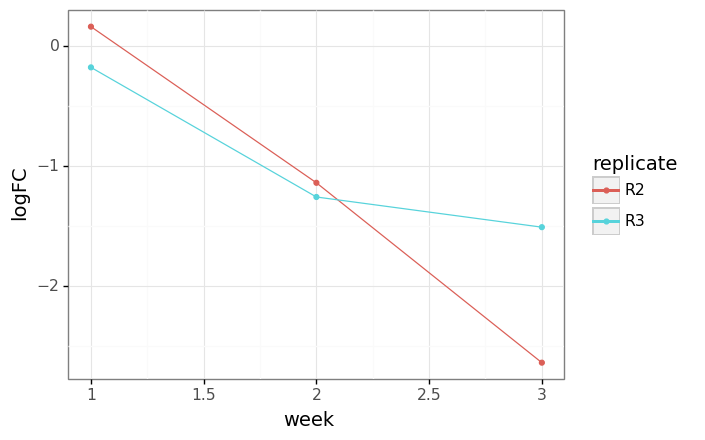

<ggplot: (8794537220738)>

In [93]:
temp = posts[0][np.inf]["z"]
temp[ posts[0][0.0]["sig"] ] = 0.
temp[ posts[0][None]["sig"] ] = 0.
weird_junc = temp.argmin()

print("Gaussian z-score ", posts[0][np.inf]["z"][weird_junc]) 
print("Student-t z-score ", posts[0][None]["z"][weird_junc]) 
print("Laplace z-score ", posts[0][0.]["z"][weird_junc]) 
weird_junc_name = essential_data.sgrnas[weird_junc]
p9.ggplot(dat[dat.sgrna == weird_junc_name], p9.aes("week","logFC",color="replicate")) + p9.geom_point() + p9.geom_line()

In [95]:
np.abs(posts[0][None]["z"])[~posts[0][None]["sig"]].max()

2.225705

## Check calibration of p values

All look a bit anti-conservative, with Gaussian being a little better. If we really cared about calling significance guides it might be worth doing a likelihood ratio test. 

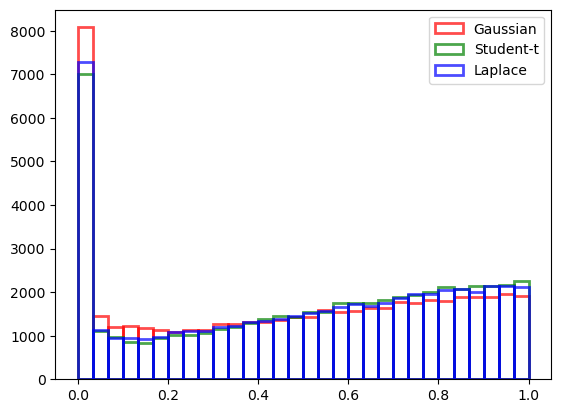

In [96]:
plt.hist(posts[0][np.inf]["p"],30,alpha=0.7,label="Gaussian",edgecolor='red', facecolor='none', linewidth=2) 
plt.hist(posts[0][None]["p"],30,alpha=0.7, label="Student-t",edgecolor='green', facecolor='none', linewidth=2) 
plt.hist(posts[0][0.]["p"],30,alpha=0.7, label="Laplace",edgecolor='blue', facecolor='none', linewidth=2) 
plt.legend()

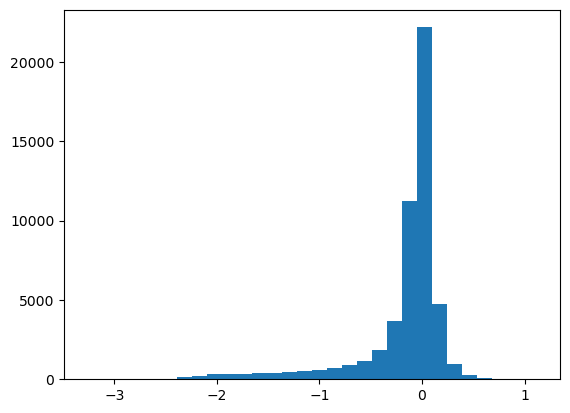

In [122]:
t_df = 0.
_ = plt.hist(posts[0][t_df]["guide_score"],30)

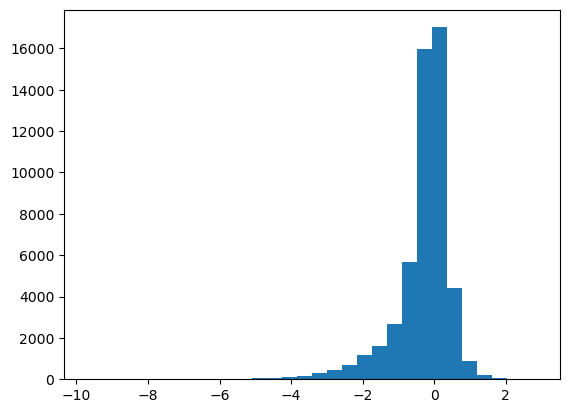

In [123]:
t_df = 0.
corrected_std = np.sqrt(2.) * posts[0][t_df]["guide_std"]
normalized_guide_score = posts[0][t_df]["guide_score"] / corrected_std[essential_data.guide_to_gene]
_ = plt.hist(normalized_guide_score,30)

In [126]:
pd.DataFrame( { 
    "guide" : essential_data.sgrnas,
    "slope" : posts[0][t_df]["guide_score"],
    "se" : posts[0][t_df]["guide_score_se"],
    "norm_slope" : normalized_guide_score,
    "norm_se" : posts[0][t_df]["guide_score_se"] / corrected_std[essential_data.guide_to_gene],
    "z" : posts[0][t_df]["z"],
    "p" : posts[0][t_df]["p"],
    "q" : posts[0][t_df]["q"]
} ).to_csv("laplace_lmm_essential.txt.gz", sep='\t', index=False)

## Isoform data

In [ ]:
isoform_data = seabass.ScreenData.from_pandas(dat[dat["type"]=="isoforms"] , device = device) 

In [138]:
res_iso = {}
posts_iso = {}
neg_elbos_iso = {}

for rep in [0,1]: 

    model, guide, losses, posts_iso[rep], optim_record = lmm_hier.robustifier(
        lmm_hier.fit, 
        10,
        isoform_data,
        hierarchical_noise = hierarchical_noise, 
        hierarchical_slope = hierarchical_slope,
        NT_model = False, 
        t_df = t_df,
        **kwargs
    )

    neg_elbos_iso[rep] = losses[-1]
    res_iso[rep] = get_perf(posts_iso[rep])


Optimizing: log_guide_std_mean log_guide_std_std
Stalled after 137 iterations. Increasing num_particles to 2.
Stalled after 50 iterations. Increasing num_particles to 4.
Stalled after 48 iterations. Increasing num_particles to 8.
Stalled after 48 iterations. Increasing num_particles to 16.
Stalled after 42 iterations. Increasing num_particles to 32.
Stalled after 39 iterations. Increasing num_particles to 64.


Text(0.5, 0, 'Guide slope')

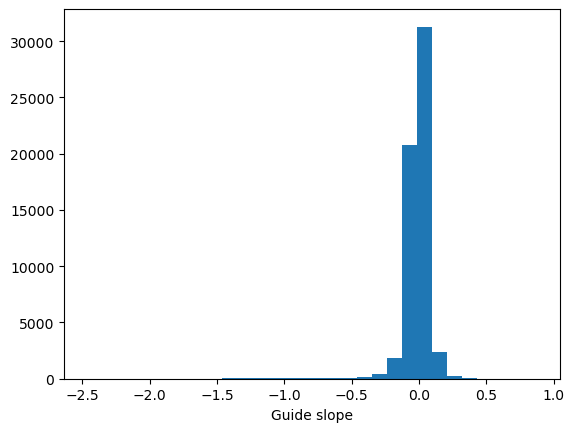

In [144]:
plt.hist(posts_iso[0]["guide_score"],30)
plt.xlabel("Guide slope")

In [153]:
np.logical_and(posts_iso[0]["z"] > 0, posts_iso[0]["sig"]).sum()

7

In [151]:
np.logical_and(posts_iso[0]["z"] < 0, posts_iso[0]["sig"]).mean()

0.005069972566586797

In [152]:
posts_iso[0]["sig"].mean()

0.0051915130048268915

In [156]:
most_positive_guide = isoform_data.sgrnas[posts_iso[0]["z"].argmax()]

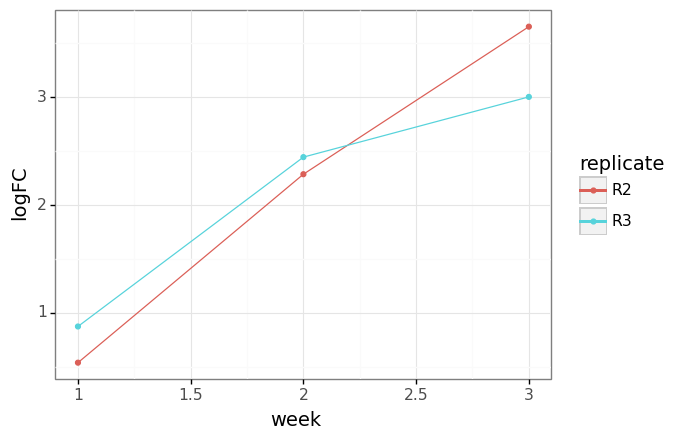

<ggplot: (8794478972444)>

In [157]:
p9.ggplot(dat[dat.sgrna == most_positive_guide], p9.aes("week","logFC",color="replicate")) + p9.geom_point() + p9.geom_line()

In [158]:
dat[dat.sgrna == most_positive_guide]

,junction,sgrna,sample,logFC,type,day,replicate,gene,junc.type,category,perc.usage,week
123762,JUNC00044881,JUNC00044881.8,DMSO_D07_R2,0.536169,isoforms,D07,R2,TRIP12,common,NaN,100.0,1
123763,JUNC00044881,JUNC00044881.8,DMSO_D14_R2,2.284578,isoforms,D14,R2,TRIP12,common,NaN,100.0,2
123764,JUNC00044881,JUNC00044881.8,DMSO_D21_R2,3.653460,isoforms,D21,R2,TRIP12,common,NaN,100.0,3
123765,JUNC00044881,JUNC00044881.8,DMSO_D07_R3,0.871959,isoforms,D07,R3,TRIP12,common,NaN,100.0,1
123766,JUNC00044881,JUNC00044881.8,DMSO_D14_R3,2.443273,isoforms,D14,R3,TRIP12,common,NaN,100.0,2
123767,JUNC00044881,JUNC00044881.8,DMSO_D21_R3,3.001963,isoforms,D21,R3,TRIP12,common,NaN,100.0,3
